### Project Overview

Accidents resulting from defective railway tracks and derailments are a frequent and serious concern, especially in Southeast Asian countries. Early and accurate detection of track faults is critical to prevent such disasters. However, manual inspection methods are often time-consuming, labor-intensive, and expensive.

To address this, a series of four notebooks were developed to explore different automated fault detection approaches, using a publicly available railway track dataset from Kaggle:  
[Railway Track Fault Detection Dataset](https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection).

1. Classical Machine Learning:  
   Using traditional techniques such as Support Vector Machine (SVM), Logistic Regression, and Random Forest classifiers on hand-crafted HOG features.

2. CNN-based Classification (without Augmentation)(This Notebook):
   Training convolutional neural network models on the original dataset to classify defective and non-defective railway tracks.

3. CNN-based Classification (with Data Augmentation):
   Enhancing the training data through augmentation techniques to improve model generalization and robustness.

4. **Anomaly Detection using Autoencoder(This Notebook):**
   Training a UNet-style convolutional autoencoder exclusively on healthy track images and detecting faults based on reconstruction error analysis.

This multi-approach study provides a comprehensive evaluation of both classical and deep learning methods for automatic railway track fault detection.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Core Python Libraries
import os
import sys
import gc
import random as rnd
from tqdm import tqdm
from PIL import Image

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2
import skimage
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

# Scikit-learn Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# TensorFlow and Keras
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation, Flatten,
                                     BatchNormalization, Conv2D, MaxPooling2D,
                                     AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
# Miscellaneous
import pickle
from numpy import expand_dims

# Visualization for Training Progress
try:
    from livelossplot import PlotLossesKeras
except ImportError:
    !pip install livelossplot
    from livelossplot import PlotLossesKeras

# Enable inline plotting for notebooks
%matplotlib inline


## Dataset Organization

The dataset consists of railway track images categorized into two classes: Defective and Non-defective.
The images are split into three subsets:
- Train set
- Validation set
- Test set

Each subset contains separate folders for defective and non-defective samples.  
The number of samples in each category and subset was printed to verify correct dataset loading.

Additionally, all defective and non-defective samples across train, validation, and test sets were concatenated into two combined DataFrames (defective and undefective) for further analysis and visualization.

### Dataset Split Summary

The dataset was evenly split between defective and undefective railway track images across training, validation, and test sets:

- Training set: 150 defective and 150 undefective samples
- Validation set: 31 defective and 31 undefective samples
- Test set: 11 defective and 11 undefective samples

This balanced split ensures that both classes are equally represented during model training and evaluation, minimizing bias and providing a fair assessment of performance.



In [ ]:
train_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
val_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'
test_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'

In [ ]:
train_df_defective = pd.DataFrame(os.listdir(train_path+'/Defective'))
val_df_defective = pd.DataFrame(os.listdir(val_path+'/Defective'))
test_df_defective = pd.DataFrame(os.listdir(test_path+'/Defective'))
train_df_undefective = pd.DataFrame(os.listdir(train_path+'/Non defective'))
val_df_undefective = pd.DataFrame(os.listdir(val_path+'/Non defective'))
test_df_undefective = pd.DataFrame(os.listdir(test_path+'/Non defective'))

In [ ]:
defective=pd.concat([train_df_defective,test_df_defective,val_df_defective], axis=0)
undefective=pd.concat([train_df_undefective,test_df_undefective,val_df_undefective], axis=0)

In [ ]:
# Print the number of defective and undefective samples in the training, validation, and test sets
print('Train samples defective: ', len(train_df_defective))
print('Val samples defective: ', len(val_df_defective))
print('Test samples defective: ', len(test_df_defective))
print()
print('Train samples undefective: ', len(train_df_undefective))
print('Val samples undefective: ', len(val_df_undefective))
print('Test samples undefective: ', len(test_df_undefective))

In [ ]:
# Display the first 31 defective training images after resizing them to 448x448 and print their original dimensions

plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_defective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, channels = img.shape
    print(f"Width: {width}, Height: {height}, Channels: {channels}")

    # Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


In [ ]:
# Display the first 31 undefective training images after resizing them to 448x448 for visual inspection

plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_undefective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Non defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


In [ ]:
# Load and preprocess defective and non-defective training images:
# - Read images
# - Convert from BGR to RGB
# - Resize to 448x448
# - Normalize pixel values to [0, 1]
# - Assign labels and one-hot encode them

X_train_defective = []
y_train_defective = []
X_train_undefective = []
y_train_undefective = []

# Load defective train images
for img_path in tqdm(train_df_defective[0]):
    img = cv2.imread(train_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_train_defective.append(img)
    y_train_defective.append(1)   # Defective label = 1

# Load non-defective train images
for img_path in tqdm(train_df_undefective[0]):
    img = cv2.imread(train_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_train_undefective.append(img)
    y_train_undefective.append(0)  # Non-defective label = 0

# Convert to NumPy arrays and normalize
X_train_defective = np.array(X_train_defective, dtype="float32") / 255.0
y_train_defective = np.array(y_train_defective)

X_train_undefective = np.array(X_train_undefective, dtype="float32") / 255.0
y_train_undefective = np.array(y_train_undefective)

# One-hot encode the labels
y_train_defective = tf.keras.utils.to_categorical(y_train_defective, num_classes=2)
y_train_undefective = tf.keras.utils.to_categorical(y_train_undefective, num_classes=2)

print('Defective samples:', X_train_defective.shape)
print('Non-defective samples:', X_train_undefective.shape)


In [ ]:
# Load and preprocess defective and non-defective validation images:
# - Read images
# - Convert from BGR to RGB
# - Resize to 448x448
# - Normalize pixel values to [0, 1]
# - Assign labels and one-hot encode them

X_val_defective = []
y_val_defective = []
X_val_undefective = []
y_val_undefective = []

# Load defective validation images
for img_path in tqdm(val_df_defective[0]):
    img = cv2.imread(val_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_val_defective.append(img)
    y_val_defective.append(1)  # Defective label = 1

# Load non-defective validation images
for img_path in tqdm(val_df_undefective[0]):
    img = cv2.imread(val_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_val_undefective.append(img)
    y_val_undefective.append(0)  # Non-defective label = 0

# Convert separately to NumPy arrays
X_val_defective = np.array(X_val_defective, dtype="float32") / 255.0
y_val_defective = np.array(y_val_defective)

X_val_undefective = np.array(X_val_undefective, dtype="float32") / 255.0
y_val_undefective = np.array(y_val_undefective)

# One-hot encode the labels
y_val_defective = tf.keras.utils.to_categorical(y_val_defective, num_classes=2)
y_val_undefective = tf.keras.utils.to_categorical(y_val_undefective, num_classes=2)

print('Validation samples (Defective):', X_val_defective.shape)
print('Validation samples (Non-defective):', X_val_undefective.shape)


In [ ]:
# Load and preprocess defective and non-defective test images:
# - Read images
# - Convert from BGR to RGB
# - Resize to 448x448
# - Normalize pixel values to [0, 1]
# - Assign labels and one-hot encode them

X_test_defective = []
y_test_defective = []
X_test_undefective = []
y_test_undefective = []

# Load defective test images
for img_path in tqdm(test_df_defective[0]):
    img = cv2.imread(test_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_test_defective.append(img)
    y_test_defective.append(1)  # Defective label = 1

# Load non-defective test images
for img_path in tqdm(test_df_undefective[0]):
    img = cv2.imread(test_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_test_undefective.append(img)
    y_test_undefective.append(0)  # Non-defective label = 0

# Convert separately to numpy arrays
X_test_defective = np.array(X_test_defective, dtype="float32") / 255.0
y_test_defective = np.array(y_test_defective)

X_test_undefective = np.array(X_test_undefective, dtype="float32") / 255.0
y_test_undefective = np.array(y_test_undefective)

# One-hot encode the labels
y_test_defective = tf.keras.utils.to_categorical(y_test_defective, num_classes=2)
y_test_undefective = tf.keras.utils.to_categorical(y_test_undefective, num_classes=2)

print('Test samples (Defective):', X_test_defective.shape)
print('Test samples (Non-defective):', X_test_undefective.shape)


### UNet-based Autoencoder for Anomaly Detection

A UNet-style convolutional autoencoder was developed to detect broken rails through anomaly detection.

- The model consists of an encoder, a bottleneck, and a decoder with skip connections to preserve spatial information.
- The encoder compresses input images into low-dimensional latent representations using convolution and max-pooling layers.
- The decoder reconstructs the images from the latent space, using upsampling and skip connections for finer detail recovery.
- The model was trained solely on healthy (non-defective) images, with the objective of minimizing the Mean Squared Error (MSE) between input and reconstructed output.
- Anomalies (defective tracks) are later identified based on higher reconstruction errors during testing.

Training was conducted for 50 epochs with a batch size of 4, using the Adam optimizer and a learning rate of 0.001.


In [ ]:
# Define a UNet-based convolutional autoencoder:
# - Encoder: progressively downsamples input using convolution and max-pooling layers
# - Bottleneck: captures compressed feature representation
# - Decoder: reconstructs the image using upsampling and skip connections
# - Output layer: sigmoid activation to generate pixel values between 0 and 1
# - Compiled with Adam optimizer and mean squared error (MSE) loss

inputs = Input(shape=(448, 448, 3))

# Encoder
e1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
e1 = Conv2D(32, (3,3), activation='relu', padding='same')(e1)
p1 = MaxPooling2D((2,2))(e1)

e2 = Conv2D(64, (3,3), activation='relu', padding='same')(p1)
e2 = Conv2D(64, (3,3), activation='relu', padding='same')(e2)
p2 = MaxPooling2D((2,2))(e2)

e3 = Conv2D(128, (3,3), activation='relu', padding='same')(p2)
e3 = Conv2D(128, (3,3), activation='relu', padding='same')(e3)
p3 = MaxPooling2D((2,2))(e3)

# Bottleneck
b = Conv2D(256, (3,3), activation='relu', padding='same')(p3)
b = Conv2D(256, (3,3), activation='relu', padding='same')(b)

# Decoder with skip connections
d3 = UpSampling2D((2,2))(b)
d3 = Concatenate()([d3, e3])
d3 = Conv2D(128, (3,3), activation='relu', padding='same')(d3)
d3 = Conv2D(128, (3,3), activation='relu', padding='same')(d3)

d2 = UpSampling2D((2,2))(d3)
d2 = Concatenate()([d2, e2])
d2 = Conv2D(64, (3,3), activation='relu', padding='same')(d2)
d2 = Conv2D(64, (3,3), activation='relu', padding='same')(d2)

d1 = UpSampling2D((2,2))(d2)
d1 = Concatenate()([d1, e1])
d1 = Conv2D(32, (3,3), activation='relu', padding='same')(d1)
d1 = Conv2D(32, (3,3), activation='relu', padding='same')(d1)

outputs = Conv2D(3, (1,1), activation='sigmoid', padding='same')(d1)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Train the UNet-based autoencoder:
# - Train only on healthy (non-defective) images
# - Input and output are the same (self-reconstruction)
# - Validation performed on healthy validation set
# - Train for 50 epochs with a batch size of 4

history_ae = autoencoder.fit(
    X_train_undefective,       # Only healthy (non-defective) training images
    X_train_undefective,       # Input = Output for Autoencoder
    epochs=50,
    batch_size=4,
    validation_data=(X_val_undefective, X_val_undefective),  # Validation set

)


In [ ]:
# Predict on test normal and test defective images separately
reconstructed_undefective = autoencoder.predict(X_test_undefective)
reconstructed_defective = autoencoder.predict(X_test_defective)


In [ ]:
# Function to plot original and reconstructed images with a big title
def plot_reconstruction(original, reconstructed, n=5, main_title="Reconstruction"):

    plt.figure(figsize=(15, 6))
    plt.suptitle(main_title, fontsize=20)  # Big title for the whole figure

    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(np.clip(original[i], 0, 1))
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.clip(reconstructed[i], 0, 1))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

# Example usage:
plot_reconstruction(X_test_undefective, reconstructed_undefective, n=5, main_title="Undefective Images Reconstruction")
plot_reconstruction(X_test_defective, reconstructed_defective, n=5, main_title="Defective Images Reconstruction")



In [ ]:
# Mean Squared Error for each image
mse_undefective = np.mean(np.square(X_test_undefective - reconstructed_undefective), axis=(1,2,3))
mse_defective = np.mean(np.square(X_test_defective - reconstructed_defective), axis=(1,2,3))


In [ ]:
print(mse_undefective)
print(mse_defective)

In [ ]:
# Plot a histogram of reconstruction MSE values:
# - Compare MSE distribution for defective and undefective samples
# - Draw a threshold line at 0.0002 to separate normal and anomalous samples
# - Visualize how reconstruction errors differ between classes

# MSE arrays
mse_undefective = np.array([
    8.53021120e-05, 1.03253224e-04, 1.37712705e-04, 7.88566322e-05,
    8.54612226e-05, 7.98169640e-05, 1.37220821e-04, 1.00445875e-04,
    7.59772010e-05, 6.29240531e-05, 9.12493779e-05
])

mse_defective = np.array([
    8.24699600e-05, 1.39880285e-04, 1.10508394e-04, 5.11880753e-05,
    3.68577865e-04, 4.26986400e-04, 1.21320780e-04, 1.42694102e-04,
    4.25057602e-04, 7.34653513e-05, 7.62822747e-05
])

# Plot
plt.figure(figsize=(10,6))
plt.hist(mse_undefective, bins=10, alpha=0.7, label='Undefective', color='blue', edgecolor='black')
plt.hist(mse_defective, bins=10, alpha=0.7, label='Defective', color='yellow', edgecolor='black')
plt.axvline(2e-04, color='green', linestyle='dashed', linewidth=2, label='Threshold (0.0002)')
plt.title('Histogram of Reconstruction MSE', fontsize=16)
plt.xlabel('MSE', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


##Histogram of Reconstruction Mean Squared Error

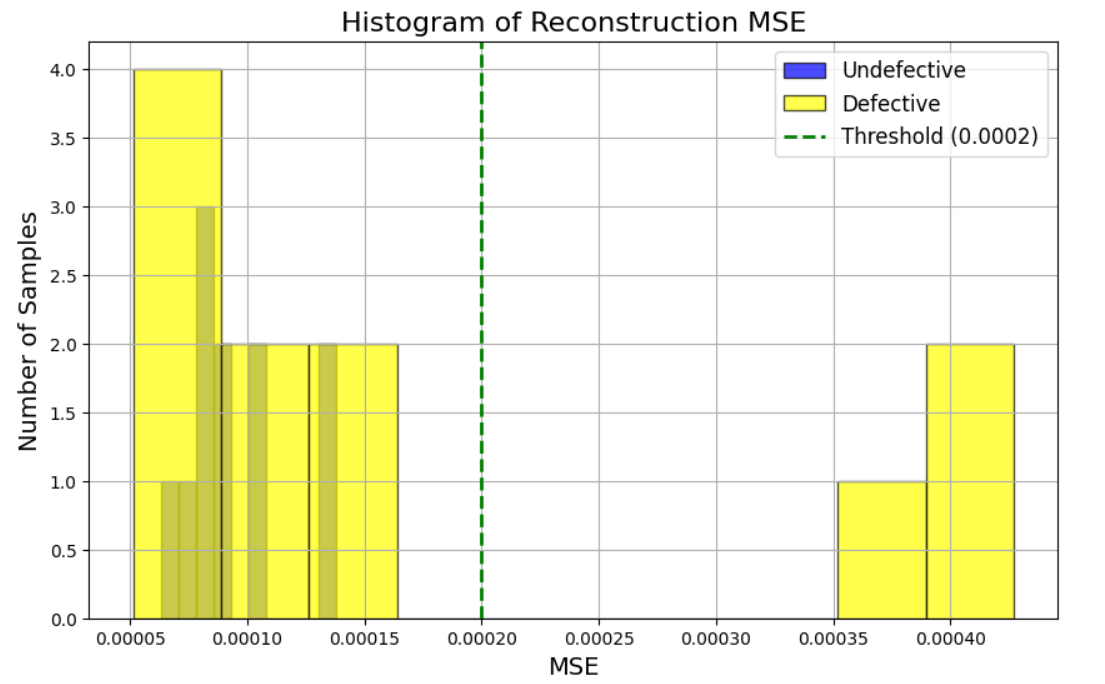

### Histogram of Reconstruction MSE for Anomaly Detection

To evaluate the anomaly detection performance of the UNet-based autoencoder, the Mean Squared Error (MSE) between the original and reconstructed images was computed for both healthy (undefective) and defective track images.

- The histogram above visualizes the distribution of reconstruction errors.
- A threshold of \( 0.0002 \) was set to distinguish anomalies: samples with MSE greater than the threshold are classified as defective.
- Most undefective samples have low reconstruction errors, while defective samples exhibit significantly higher errors.
- This clear separation validates the effectiveness of using reconstruction MSE as an anomaly indicator for broken rail detection.

Overall, the histogram confirms that the autoencoder successfully learned the structure of healthy tracks and struggles to reconstruct defective tracks, leading to higher errors for anomalies.
